In [ ]:
!pip install fastai --upgrade -q

     |████████████████████████████████| 186 kB 5.5 MB/s 
     |████████████████████████████████| 56 kB 1.8 MB/s 


In [ ]:
# Download dataset with Kaggle API
# ! kaggle datasets download lavaman151/plantifydr-dataset --unzip

In [ ]:
! pip install -q kaggle
! mkdir ~/.kaggle
%cd /content
! cp kaggle.json ~/.kaggle/
! chmod 600 ~/.kaggle/kaggle.json
!kaggle datasets download lavaman151/plantifydr-dataset

mkdir: cannot create directory ‘/root/.kaggle’: File exists
/content
100% 2.57G/2.58G [00:36<00:00, 59.0MB/s]
100% 2.58G/2.58G [00:36<00:00, 76.5MB/s]


In [ ]:
!unzip plantifydr-dataset.zip

Le flux de sortie a été tronqué et ne contient que les 5000 dernières lignes.
  inflating: PlantDiseasesDataset/Tomato/train/Tomato Yellow Leaf Curl Virus/TomatoYellowCurlVirus(3679).JPG  
  inflating: PlantDiseasesDataset/Tomato/train/Tomato Yellow Leaf Curl Virus/TomatoYellowCurlVirus(368).JPG  
  inflating: PlantDiseasesDataset/Tomato/train/Tomato Yellow Leaf Curl Virus/TomatoYellowCurlVirus(3680).JPG  
  inflating: PlantDiseasesDataset/Tomato/train/Tomato Yellow Leaf Curl Virus/TomatoYellowCurlVirus(3681).JPG  
  inflating: PlantDiseasesDataset/Tomato/train/Tomato Yellow Leaf Curl Virus/TomatoYellowCurlVirus(3682).JPG  
  inflating: PlantDiseasesDataset/Tomato/train/Tomato Yellow Leaf Curl Virus/TomatoYellowCurlVirus(3683).JPG  
  inflating: PlantDiseasesDataset/Tomato/train/Tomato Yellow Leaf Curl Virus/TomatoYellowCurlVirus(3684).JPG  
  inflating: PlantDiseasesDataset/Tomato/train/Tomato Yellow Leaf Curl Virus/TomatoYellowCurlVirus(3685).JPG  
  inflating: PlantDiseasesDataset/T

In [ ]:
from pathlib import Path
path = Path('./PlantDiseasesDataset')


In [ ]:
plant_list = ['Apple','Bell pepper','Cherry','Citrus','Corn','Grape','Peach','Potato','Strawberry','Tomato']
plant = 'Tomato'

In [ ]:
model_path = Path(path/plant)

In [ ]:
from fastai.vision.all import *

In [ ]:
batch_tfms=[Normalize.from_stats(*imagenet_stats)]

In [ ]:
dls = ImageDataLoaders.from_folder(path/plant,train='train',valid_pct=0.2,seed=1000,item_tfms=Resize(224),
                                   batch_tfms=batch_tfms,bs=128)

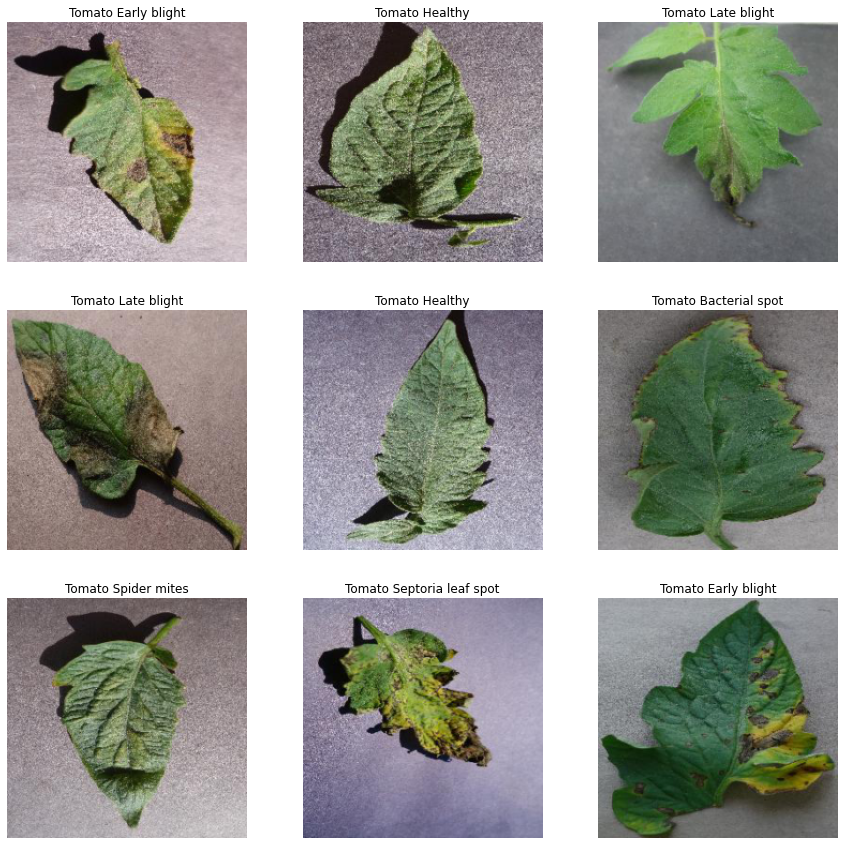

In [ ]:
dls.show_batch(figsize=(15,15))

In [ ]:
f1 = F1Score(average='weighted')
mcc = MatthewsCorrCoef()

In [ ]:
learn = cnn_learner(dls, models.resnet50,loss_func=LabelSmoothingCrossEntropy(),metrics=[accuracy,f1,mcc],
                    cbs=[SaveModelCallback(monitor='accuracy'),EarlyStoppingCallback(monitor='accuracy',patience=2)
                         ,ShowGraphCallback()],model_dir=model_path/'models').to_fp16()

Downloading: "https://download.pytorch.org/models/resnet50-0676ba61.pth" to /root/.cache/torch/hub/checkpoints/resnet50-0676ba61.pth


  0%|          | 0.00/97.8M [00:00<?, ?B/s]

/usr/local/lib/python3.7/dist-packages/torch/nn/functional.py:718: UserWarning: Named tensors and all their associated APIs are an experimental feature and subject to change. Please do not use them for anything important until they are released as stable. (Triggered internally at  /pytorch/c10/core/TensorImpl.h:1156.)
  return torch.max_pool2d(input, kernel_size, stride, padding, dilation, ceil_mode)
/usr/local/lib/python3.7/dist-packages/torch/cuda/amp/autocast_mode.py:120: UserWarning: torch.cuda.amp.autocast only affects CUDA ops, but CUDA is not available.  Disabling.
  warnings.warn("torch.cuda.amp.autocast only affects CUDA ops, but CUDA is not available.  Disabling.")


In [ ]:
learn.fit_one_cycle(20)

/usr/local/lib/python3.7/dist-packages/torch/cuda/amp/grad_scaler.py:115: UserWarning: torch.cuda.amp.GradScaler is enabled, but CUDA is not available.  Disabling.
  warnings.warn("torch.cuda.amp.GradScaler is enabled, but CUDA is not available.  Disabling.")


epoch,train_loss,valid_loss,accuracy,f1_score,matthews_corrcoef,time


In [ ]:
learn.save(model_path/f'models/{plant}')

In [ ]:
learn = cnn_learner(dls, models.resnet50).load(model_path/f'models/{plant}')

In [ ]:
learn.summary()

In [ ]:
learn.show_results(max_n=10)

In [ ]:
interp = ClassificationInterpretation.from_learner(learn)
losses,idxs = interp.top_losses()
interp.plot_confusion_matrix(figsize=(12,12))

In [ ]:
learn.export(f'{plant}.pkl')

In [ ]:
# convert to onnx for model visualization
input_names = [ "actual_input_1" ] + [ "learned_%d" % i for i in range(16) ]
output_names = [ "output1" ]

dummy_input = torch.randn(10, 3, 224, 224, device='cuda')

torch.onnx.export(learn.model.cuda(), dummy_input, "Resnet50.onnx", verbose=True, input_names=input_names,
                  output_names=output_names)